In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Load file paths

In [2]:
RAV = "../data/archive/audio_speech_actors_01-24/"
dir_list = os.listdir(RAV)
dir_list.sort()
print(dir_list)

['.DS_Store', 'Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
dir_list = dir_list[1:] # get rid of '.DS_Store'
# look at the RAV dataset
emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

female_neutral     144
male_neutral       144
female_happy        96
female_sad          96
female_fear         96
male_surprise       96
female_angry        96
male_disgust        96
female_surprise     96
male_sad            96
male_fear           96
male_happy          96
male_angry          96
female_disgust      96
Name: labels, dtype: int64

In [4]:
RAV_df.head()

,labels,source,path
0,male_surprise,RAVDESS,../data/archive/audio_speech_actors_01-24/Acto...
1,male_surprise,RAVDESS,../data/archive/audio_speech_actors_01-24/Acto...
2,male_angry,RAVDESS,../data/archive/audio_speech_actors_01-24/Acto...
3,male_fear,RAVDESS,../data/archive/audio_speech_actors_01-24/Acto...
4,male_fear,RAVDESS,../data/archive/audio_speech_actors_01-24/Acto...


## Data Exploration

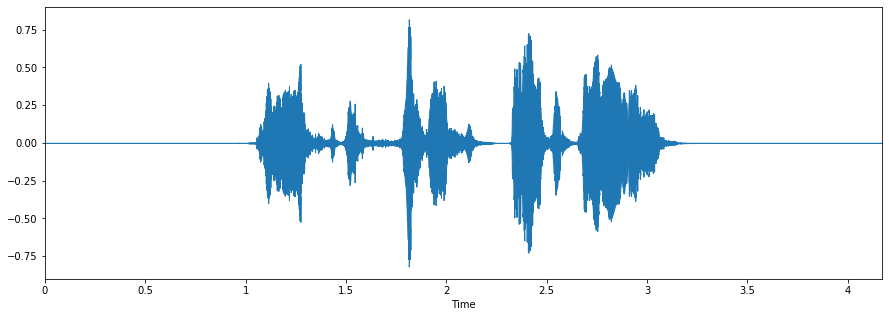

In [10]:
# Pick a track: female, intense angry, speaking "Dogs"
fname = RAV + 'Actor_14/03-01-05-02-02-01-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

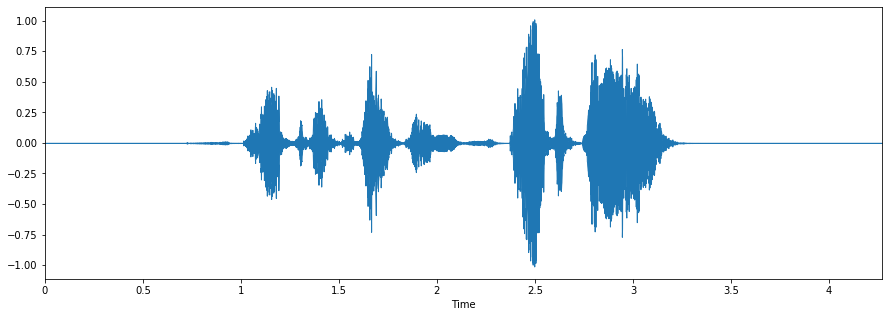

In [20]:
# Pick a track: female, intense angry, speaking "Kids"
fname = RAV + 'Actor_14/03-01-05-02-01-01-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

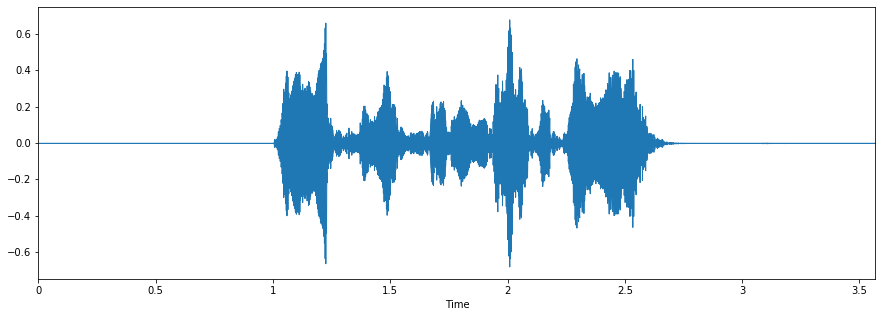

In [12]:
# Pick a track: male, intense angry, speaking "Dogs"
fname = RAV + 'Actor_13/03-01-05-02-02-01-13.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

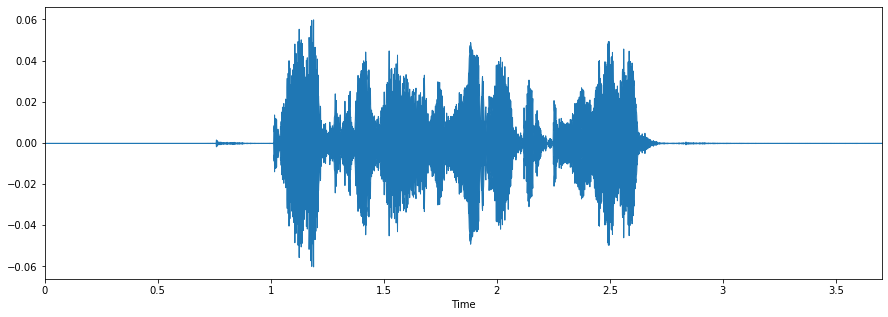

In [13]:
# Pick a track: female, surprised, speaking "Dogs"
fname = RAV + 'Actor_14/03-01-08-02-02-01-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

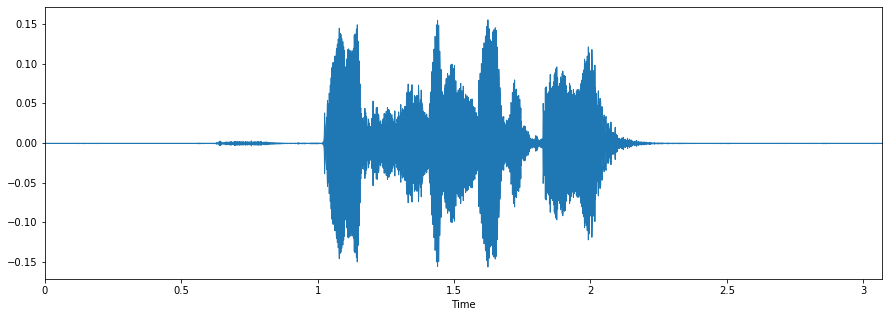

In [14]:
# Pick a track: male, surprised, speaking "Dogs"
fname = RAV + 'Actor_11/03-01-08-02-02-01-11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

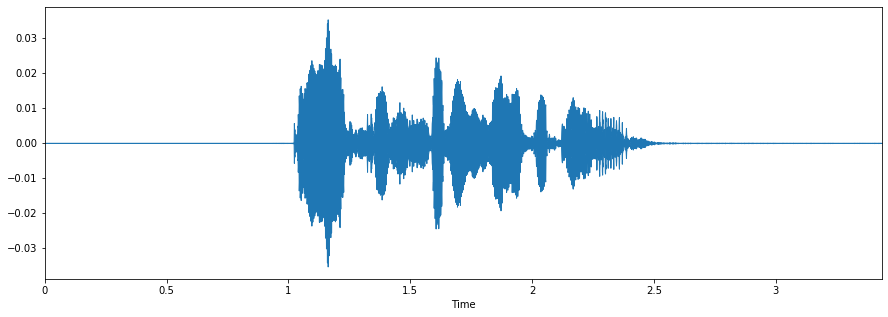

In [17]:
# Pick a track: female, neutral, speaking "Dogs"
fname = RAV + 'Actor_20/03-01-01-01-02-01-20.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

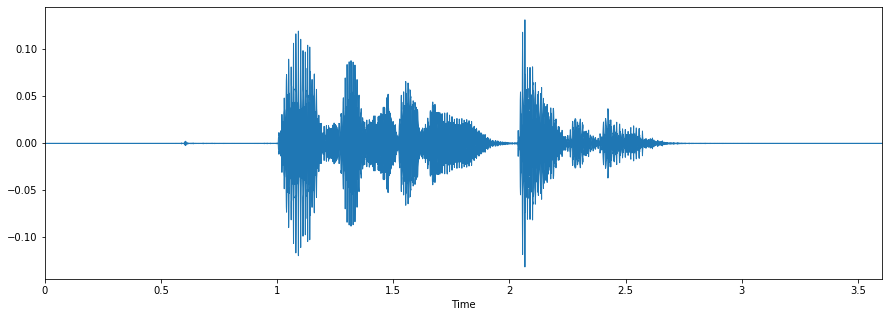

In [18]:
# Pick a track: male, neutral, speaking "Dogs"
fname = RAV + 'Actor_21/03-01-01-01-02-01-21.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

### Conclusion: 
Distinctive waveforms could be observed from the plot, even with diffirent sentences and different genders. This suggested the classification of emotions could possibly work.

## Melspec Transformation

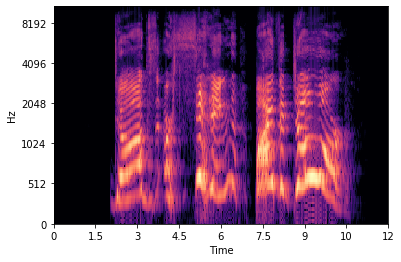

In [5]:
# Pick a track: female, intense angry, speaking "Dogs"
path = RAV + 'Actor_14/03-01-05-02-02-01-14.wav'  
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)  

def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db
n_melspec = 60
#melspec = librosa.feature.melspectrogram(X, n_mels=n_melspec)
melspec = getMELspectrogram(X, sample_rate)
librosa.display.specshow(melspec, y_axis='mel', x_axis='time')

## MFCC Transformation

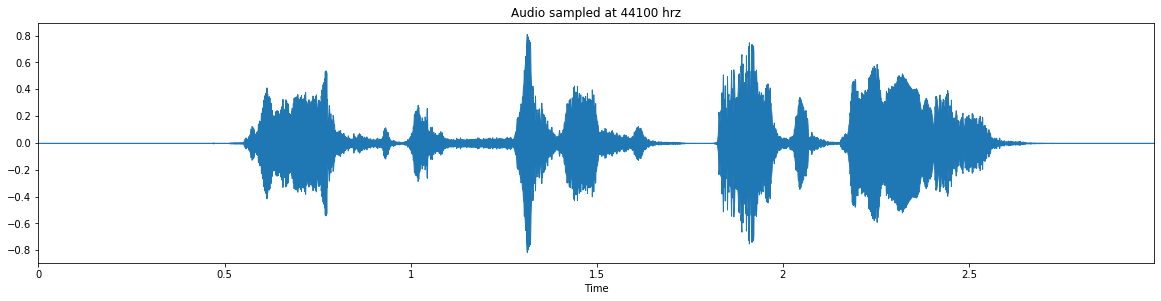

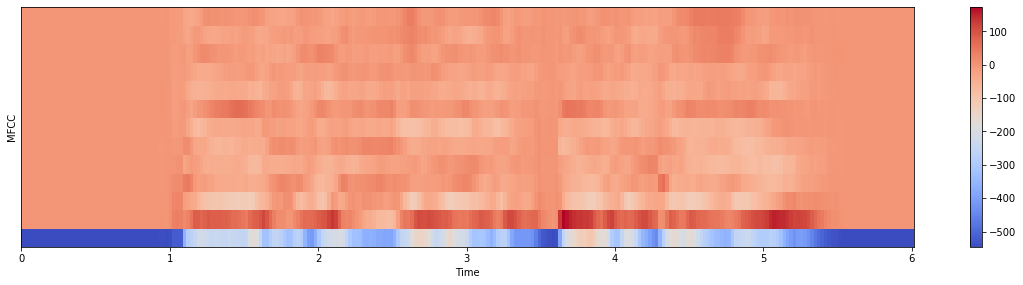

In [27]:
# Pick a track: female, intense angry, speaking "Dogs"
path = RAV + 'Actor_14/03-01-05-02-02-01-14.wav'  
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()


259
259


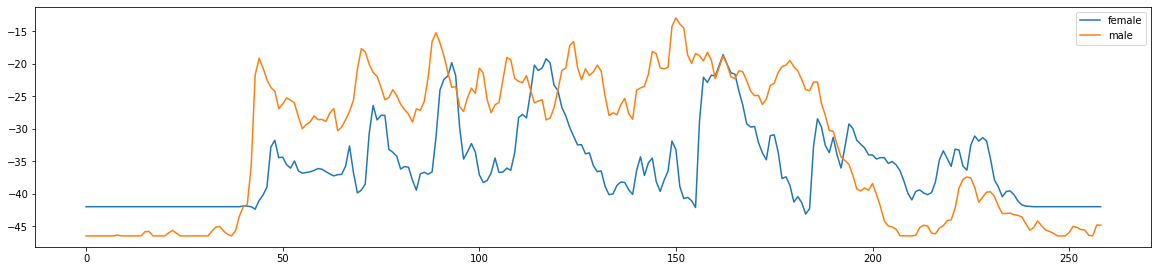

In [34]:
# MFCC audio waves

# Pick a track: female, intense angry, speaking "Dogs"
path = RAV + 'Actor_14/03-01-05-02-02-01-14.wav'  
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Pick a track: male, intense angry, speaking "Dogs"
path = RAV + 'Actor_13/03-01-05-02-02-01-13.wav' 
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

##  CREMA-dataset

In [6]:
CREMA = "../data/AudioWAV/"

dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

len(dir_list)

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


7442

In [7]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_fear         671
male_happy        671
male_sad          671
male_disgust      671
female_sad        600
female_fear       600
female_angry      600
female_disgust    600
female_happy      600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

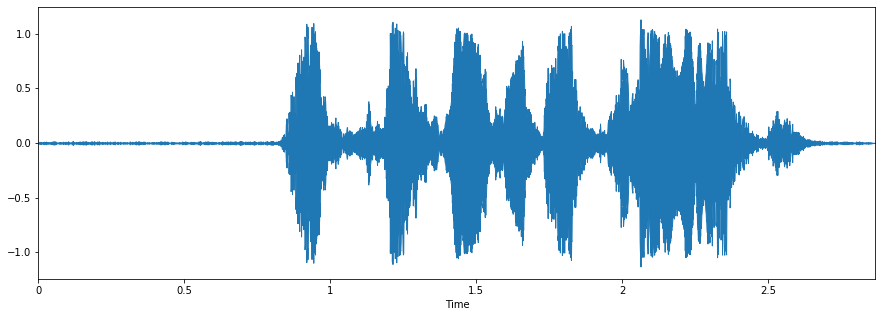

In [8]:
# use the well known Librosa library for this task 
fname = CREMA + '1008_IEO_ANG_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

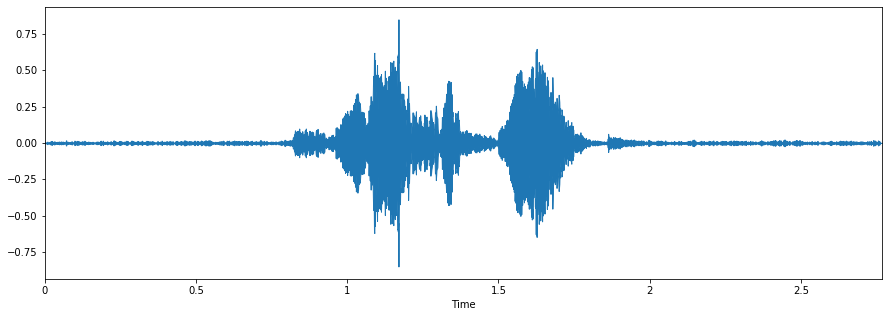

In [11]:
# A fearful track
fname = CREMA + '1012_IEO_FEA_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [5]:
# df = pd.concat([RAV_df, CREMA_df], axis = 0)
df = RAV_df
print(df.labels.value_counts())
df.head()
df.to_csv("../metadata/Data_path.csv",index=False)

female_neutral     144
male_neutral       144
female_happy        96
female_sad          96
female_fear         96
male_surprise       96
female_angry        96
male_disgust        96
female_surprise     96
male_sad            96
male_fear           96
male_happy          96
male_angry          96
female_disgust      96
Name: labels, dtype: int64


In [34]:
df.sample(n=5)

,labels,source,path
5702,male_sad,CREMA,../data/AudioWAV/1070_TAI_SAD_XX.wav
59,male_disgust,CREMA,../data/AudioWAV/1001_TAI_DIS_XX.wav
289,female_neutral,CREMA,../data/AudioWAV/1004_IWL_NEU_XX.wav
5525,male_neutral,CREMA,../data/AudioWAV/1068_IWW_NEU_XX.wav
2599,male_angry,CREMA,../data/AudioWAV/1032_WSI_ANG_XX.wav
